In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import numpy as np
import pandas
import cv2
import matplotlib.pyplot as plt
import csv
import random
from skimage.transform import rotate
import joblib
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#### Class names

In [3]:
class_names = {
    0: "Speed limit (20km/h)", 1: "Speed limit (30km/h)", 2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)", 4: "Speed limit (70km/h)", 5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)", 7: "Speed limit (100km/h)", 8: "Speed limit (120km/h)",
    9: "No passing", 10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection", 12: "Priority road", 13: "Yield",
    14: "Stop", 15: "No vehicles", 16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry", 18: "General caution", 19: "Dangerous curve to the left",
    20: "Dangerous curve to the right", 21: "Double curve", 22: "Bumpy road",
    23: "Slippery road", 24: "Road narrows on the right", 25: "Road work",
    26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing",
    29: "Bicycles crossing", 30: "Beware of ice/snow", 31: "Wild animals crossing",
    32: "End of all speed and passing limits", 33: "Turn right ahead",
    34: "Turn left ahead", 35: "Ahead only", 36: "Go straight or right",
    37: "Go straight or left", 38: "Keep right", 39: "Keep left",
    40: "Roundabout mandatory", 41: "End of no passing",
    42: "End of no passing for vehicles over 3.5 metric tons"
}

#### Load Data

In [4]:
augmented_I_RGB = np.load('augmented_I_RGB.npy')      # Shape: (N, 32, 32, 3)
augmented_I_Gray = np.load('augmented_I_Gray.npy')    # Shape: (N, 32, 32)
augmented_L = np.load('augmented_L.npy')              # Shape: (N,)

#Verify shapes
print(f"RGB images: {augmented_I_RGB.shape}")
print(f"Grayscale images: {augmented_I_Gray.shape}")
print(f"Labels: {augmented_L.shape}")

RGB images: (78418, 32, 32, 3)
Grayscale images: (78418, 32, 32)
Labels: (78418,)


#### Simple CNN

In [5]:
model = models.Sequential()
#in
model.add(layers.InputLayer(input_shape=(32, 32, 3)))#use (32,32 for grayscale)
#Convolutional Block 1
model.add(layers.Conv2D(192, (5, 5), strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.LayerNormalization())  # Using LayerNorm as LRN is less common now
#conv Block 2
model.add(layers.Conv2D(256, (5, 5), strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.LayerNormalization())
    
#conv block 3
model.add(layers.Conv2D(192, (3, 3), strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.LayerNormalization())

#Output block
model.add(layers.Flatten())
model.add(layers.Dense(43, activation='softmax'))

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
X = augmented_I_RGB
y = augmented_L  
print(len(X),len(y))

78418 78418


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
y_train_int = np.array(y_train).astype(int)
y_train_onehot = to_categorical(y_train_int, num_classes=43)

In [9]:
early_stopping = callbacks.EarlyStopping(
        monitor='accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
)

In [10]:
history = model.fit(
    X_train, y_train_onehot,
    epochs=50,  # Set high since we're using early stopping
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
1961/1961 [==============================] - 34s 16ms/step - loss: 1.7855 - accuracy: 0.5125
Epoch 2/50
1961/1961 [==============================] - 32s 16ms/step - loss: 0.0425 - accuracy: 0.9873
Epoch 3/50
1961/1961 [==============================] - 52s 27ms/step - loss: 0.0212 - accuracy: 0.9935
Epoch 4/50
1961/1961 [==============================] - 24s 12ms/step - loss: 0.0168 - accuracy: 0.9947
Epoch 5/50
1961/1961 [==============================] - 25s 13ms/step - loss: 0.0118 - accuracy: 0.9965
Epoch 6/50
1961/1961 [==============================] - 24s 12ms/step - loss: 0.0101 - accuracy: 0.9967
Epoch 7/50
1961/1961 [==============================] - 24s 12ms/step - loss: 0.0075 - accuracy: 0.9975
Epoch 8/50
1961/1961 [==============================] - 24s 12ms/step - loss: 0.0071 - accuracy: 0.9975
Epoch 9/50
1961/1961 [==============================] - 24s 12ms/step - loss: 0.0059 - accuracy: 0.9981
Epoch 10/50
1961/1961 [==============================] - 24s 12m

#### Evaluation

Test Accuracy: 0.9994
Test Loss: 0.0019
491/491 [==============================] - 2s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       1.00      1.00      1.00       888
           2       1.00      1.00      1.00       900
           3       1.00      1.00      1.00       564
           4       1.00      1.00      1.00       792
           5       1.00      1.00      1.00       744
           6       1.00      1.00      1.00       168
           7       1.00      1.00      1.00       576
           8       1.00      1.00      1.00       564
           9       1.00      1.00      1.00       588
          10       1.00      1.00      1.00       804
          11       1.00      1.00      1.00       528
          12       1.00      1.00      1.00       840
          13       1.00      1.00      1.00       864
          14       1.00      1.00      1.00       312
          15    

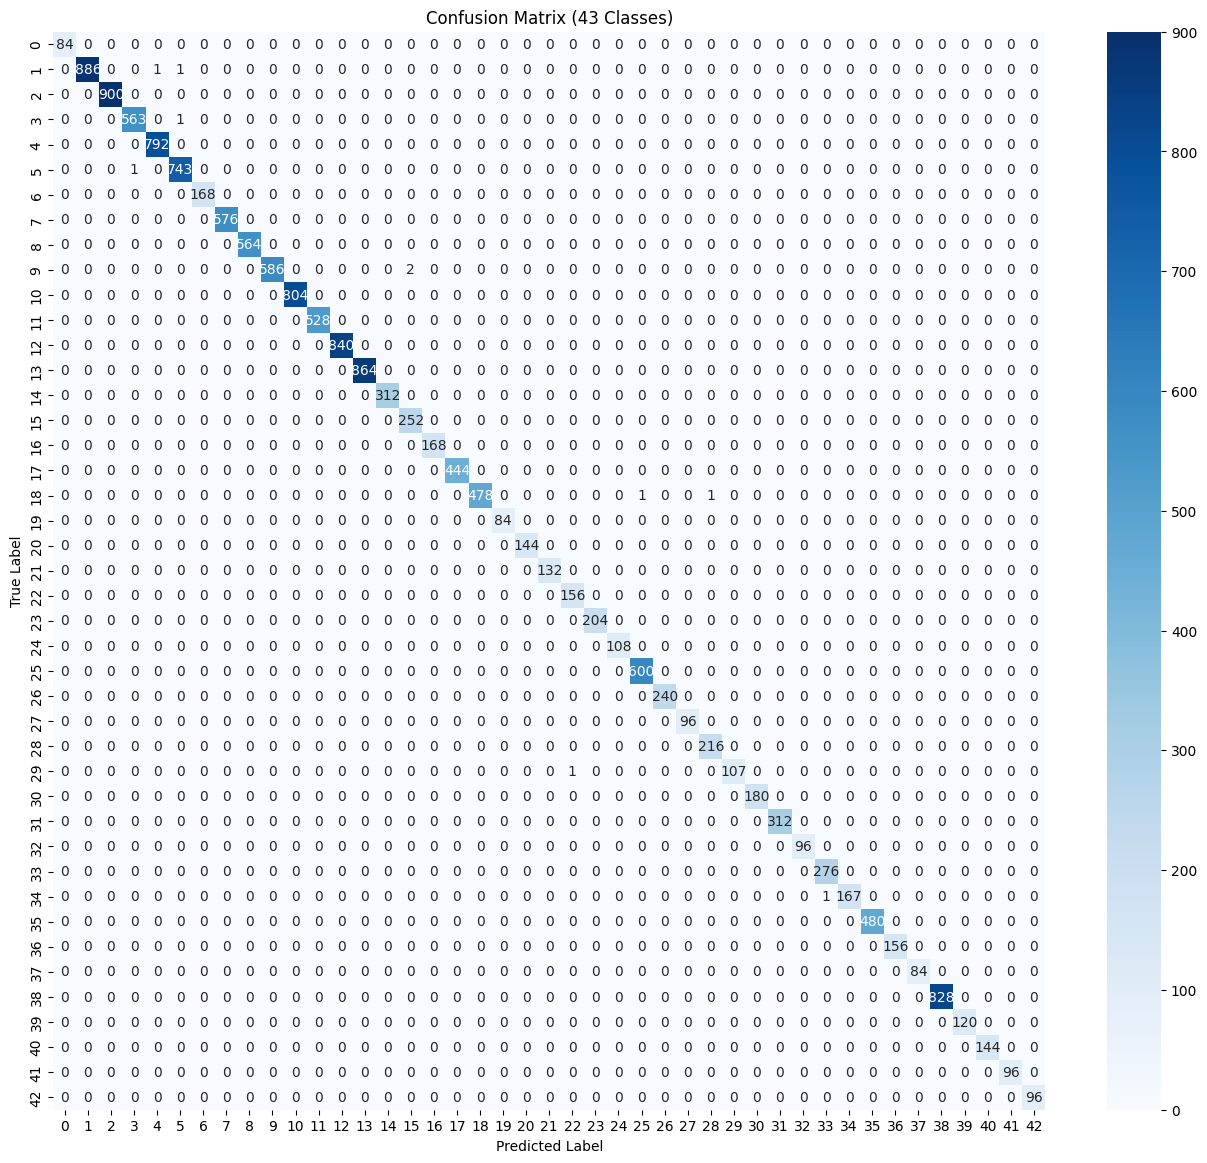

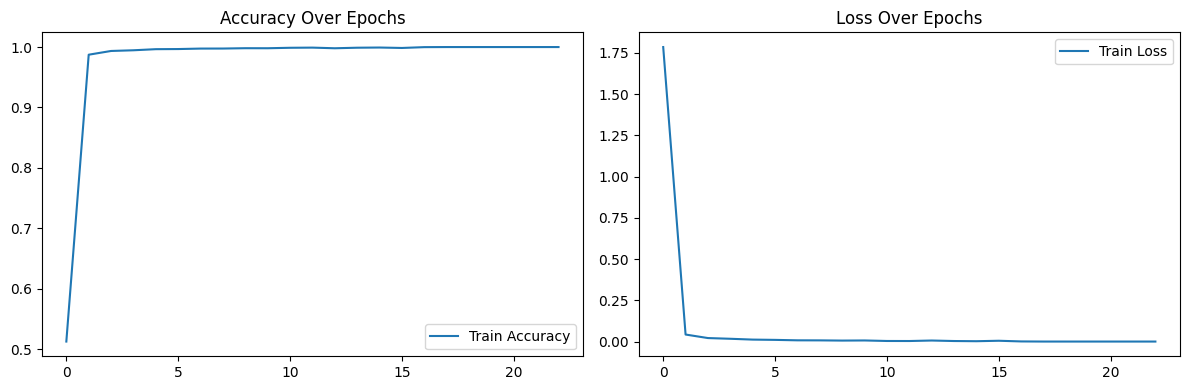

In [25]:
y_test_int = np.array(y_test).astype(int)
y_test_onehot = to_categorical(y_test_int, num_classes=43)
# 1. Basic Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# 2. Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 3. Check if y_test needs reshaping (only if you get shape errors)
if len(y_test.shape) > 1 and y_test.shape[1] == 1:
    y_test = y_test.flatten()

# 4. Classification Report
print("\nClassification Report:")
print(classification_report(y_test_int, (y_pred_classes)))

# 5. Confusion Matrix (for 43 classes, we'll make it large)
plt.figure(figsize=(16, 14))
cm = confusion_matrix(y_test_int, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(43), yticklabels=range(43))
plt.title('Confusion Matrix (43 Classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 6. Training History Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.tight_layout()
plt.show()